In [2]:
!pip install imutils


In [3]:
from imutils import paths
import os
import numpy as np
import random
import pandas as pd
from sklearn.model_selection import train_test_split

import cv2
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage import morphology
import time

import keras,math
from keras.applications.inception_v3 import InceptionV3 
from keras.layers import GlobalAveragePooling2D,BatchNormalization
from keras.layers import Dense,Dropout
from keras.models import Model

import tensorflow as tf
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers

import tensorflow as tf
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn import metrics

2025-05-25 14:30:07.356417: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748183407.561361      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748183407.616724      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


1-1: Create temporary folders



In [4]:
!mkdir /tmp/prepared_data/

!mkdir /tmp/prepared_data/benign
!mkdir /tmp/prepared_data/PreB
!mkdir /tmp/prepared_data/ProB
!mkdir /tmp/prepared_data/EarlyPreB

!mkdir /tmp/prepared_test/

!mkdir /tmp/prepared_test/benign
!mkdir /tmp/prepared_test/PreB
!mkdir /tmp/prepared_test/ProB
!mkdir /tmp/prepared_test/EarlyPreB

1-2: Splitting data into testing data and training data (10/90)



In [5]:
data_dir  = '../input/blood-cell-cancer-all-4class/Blood cell Cancer [ALL]'
data_list = sorted(list(paths.list_images(data_dir)))

random.seed(88)
random.shuffle(data_list)

train_list, test_list = train_test_split(data_list, train_size=0.90, shuffle=True, random_state=88)

print('number of testing list -:',len(test_list))
print('number of training list-:',len(train_list))

number of testing list -: 325
number of training list-: 2917


In [6]:
print('Number of samples in dataset:',len(list(paths.list_images("../input/blood-cell-cancer-all-4class/Blood cell Cancer [ALL]"))),'\n')

print('Number of samples in each class:','\n')
print("#1 Benign ---------------:", len(list(paths.list_images("../input/blood-cell-cancer-all-4class/Blood cell Cancer [ALL]/Benign"))))
print("#2 Malignant[Early PreB] :", len(list(paths.list_images("../input/blood-cell-cancer-all-4class/Blood cell Cancer [ALL]/[Malignant] early Pre-B"))))
print("#3 Malignant[PreB] ------:", len(list(paths.list_images("../input/blood-cell-cancer-all-4class/Blood cell Cancer [ALL]/[Malignant] Pre-B"))))
print("#4 Malignant[ProB] ------:", len(list(paths.list_images("../input/blood-cell-cancer-all-4class/Blood cell Cancer [ALL]/[Malignant] Pro-B"))))

Number of samples in dataset: 3242 

Number of samples in each class: 

#1 Benign ---------------: 512
#2 Malignant[Early PreB] : 979
#3 Malignant[PreB] ------: 955
#4 Malignant[ProB] ------: 796


1-3: Preparation and storage of test data



In [ ]:
p=0

for img in test_list[:]:
    
    i= cv2.imread(img)    
    i= cv2.resize(i,(224,224))
    lable= img.split(os.path.sep)[4]
  
    if (lable=="Benign"):
        b= ('/tmp/prepared_test/benign/'+lable+str(p)+'.png') 
    if (lable=="[Malignant] Pre-B"):
        b= ('/tmp/prepared_test/PreB/'+lable+str(p)+'.png')  
    if (lable=="[Malignant] Pro-B"):
        b= ('/tmp/prepared_test/ProB/'+lable+str(p)+'.png') 
    if (lable=="[Malignant] early Pre-B"):
        b= ('/tmp/prepared_test/EarlyPreB/'+lable+str(p)+'.png')
    p+=1
    cv2.imwrite(b,i)
    

1-4: Preparation and storage of training data

Description: each original sample of the training data is segmented and then stored with the original sample as two separate samples.

In [8]:
p=0
tic = time.perf_counter()

for img in train_list[:]:
    
    i= cv2.imread(img)    
    i= cv2.resize(i,(224,224))
    lable= img.split(os.path.sep)[4]
    
    if (lable=="Benign"):
        b= ('/tmp/prepared_data/benign/'+lable+str(p)+'.png') 
    if (lable=="[Malignant] Pre-B"):
        b= ('/tmp/prepared_data/PreB/'+lable+str(p)+'.png')  
    if (lable=="[Malignant] Pro-B"):
        b= ('/tmp/prepared_data/ProB/'+lable+str(p)+'.png') 
    if (lable=="[Malignant] early Pre-B"):
        b= ('/tmp/prepared_data/EarlyPreB/'+lable+str(p)+'.png')
    p+=1
    cv2.imwrite(b,i)
    
    #-------- Segmentation ---------
    i= cv2.cvtColor(i, cv2.COLOR_BGR2RGB)
    i_lab = cv2.cvtColor(i, cv2.COLOR_RGB2LAB)        #RGB -> LAB
    l,a,b = cv2.split(i_lab)                         
    i2 = a.reshape(a.shape[0]*a.shape[1],1)
    km = KMeans(n_clusters=7, random_state=0, n_init=10).fit(i2)
    p2s= km.cluster_centers_[km.labels_]
    ic= p2s.reshape(a.shape[0],a.shape[1])
    ic = ic.astype(np.uint8)
    r,t = cv2.threshold(ic,141,255 ,cv2.THRESH_BINARY) #Binary Thresholding
    fh = ndi.binary_fill_holes(t)                      #fill holes
    m1 = morphology.remove_small_objects(fh, 200)
    m2 = morphology.remove_small_holes(m1,250)
    m2 = m2.astype(np.uint8)  
    out = cv2.bitwise_and(i, i, mask=m2)
    
    if (lable=="Benign"):
        b= ('/tmp/prepared_data/benign/'+lable+str(p)+'.png') 
    if (lable=="[Malignant] Pre-B"):
        b= ('/tmp/prepared_data/PreB/'+lable+str(p)+'.png')  
    if (lable=="[Malignant] Pro-B"):
        b= ('/tmp/prepared_data/ProB/'+lable+str(p)+'.png') 
    if (lable=="[Malignant] early Pre-B"):
        b= ('/tmp/prepared_data/EarlyPreB/'+lable+str(p)+'.png')
    p+=1
    out= cv2.cvtColor(out, cv2.COLOR_RGB2BGR)
    cv2.imwrite(b,out)
    
toc2 = time.perf_counter()
print(f"2917 samples processed in { ((toc2 - tic)/60) } minutes")

2917 samples processed in 10.893499932083333 minutes


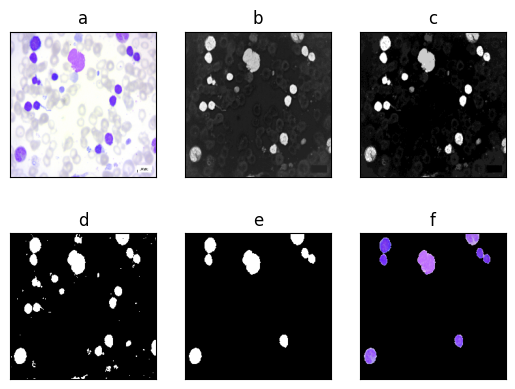

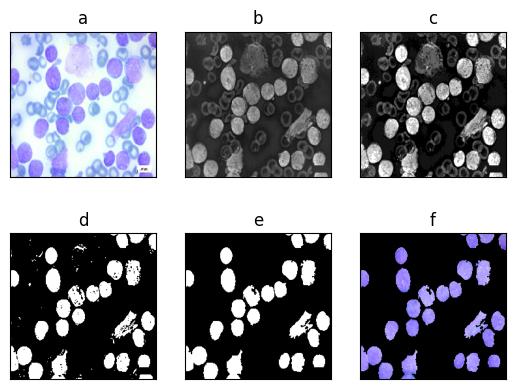

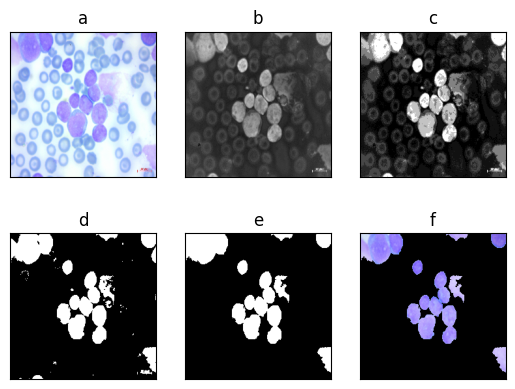

In [9]:
#----- print some samples of training dataset -------

n= 3

o_img=[]
a_img=[]
c_img=[]
b_img=[]
m_img=[]
out_img=[]

random.seed(865)
random.shuffle(data_list)

for img in data_list[:n]:
    i= cv2.imread(img)    
    i= cv2.cvtColor(i, cv2.COLOR_BGR2RGB)
    i= cv2.resize(i,(224,224))
    o_img.append(i)
    i_lab = cv2.cvtColor(i, cv2.COLOR_RGB2LAB)
    l,a,b = cv2.split(i_lab)
    a_img.append(a)
    i2 = a.reshape(a.shape[0]*a.shape[1],1)
    km = KMeans(n_clusters=7, random_state=0, n_init=10).fit(i2)
    p2s= km.cluster_centers_[km.labels_]
    ic= p2s.reshape(a.shape[0],a.shape[1])
    ic = ic.astype(np.uint8)
    c_img.append(ic)
    r,t = cv2.threshold(ic,141,255 ,cv2.THRESH_BINARY)
    b_img.append(t)    
    fh = ndi.binary_fill_holes(t)   
    m1 = morphology.remove_small_objects(fh, 200)
    m2 = morphology.remove_small_holes(m1,250)
    #m2 = ndi.binary_fill_holes(m2)  
    #m1 = m1.astype(np.uint8)
    #m1_imgs.append(m1)
    m2 = m2.astype(np.uint8)  
    m_img.append(m2)
    out = cv2.bitwise_and(i, i, mask=m2)
    out_img.append(out)
    
for j in range(n):    
    for t in range(1):
        #print('=>',j+1,':')
        plt.subplot(2,3,1+t),plt.imshow(o_img[j])
        plt.title('a'),plt.xticks([]),plt.yticks([])
        plt.subplot(2,3,2+t),plt.imshow(a_img[j],'gray')
        plt.title('b'),plt.xticks([]),plt.yticks([])
        plt.subplot(2,3,3+t),plt.imshow(c_img[j],'gray')
        plt.title('c'),plt.xticks([]),plt.yticks([])
        plt.subplot(2,3,4+t),plt.imshow(b_img[j],'gray')
        plt.title('d'),plt.xticks([]),plt.yticks([])
        plt.subplot(2,3,5+t),plt.imshow(m_img[j],'gray')
        plt.title('e'),plt.xticks([]),plt.yticks([])
        plt.subplot(2,3,6+t),plt.imshow(out_img[j])
        plt.title('f'),plt.xticks([]),plt.yticks([])
    plt.show()  

**Step 2: Prepare data for training
**

2-1: Create dataframe from prepared data



In [10]:
#------- test Datafarame ---------

prepared_data_path = '/tmp/prepared_test/'
prepared_data_list_filenames = (sorted(list(paths.list_images(prepared_data_path))))
random.shuffle(prepared_data_list_filenames)
prepared_data_list_labels = []

for line in prepared_data_list_filenames:
    prepared_data_list_labels.append(line.split(os.path.sep)[3])

I_series = pd.Series(prepared_data_list_filenames, name='filenames')
L_series = pd.Series(prepared_data_list_labels, name='labels')
test_df = pd.concat( [I_series, L_series], axis=1) 

print('-- test Datafarame --')
print(test_df.head())
#print number of each class:        
a=test_df['labels'].value_counts()
a

-- test Datafarame --
                                           filenames     labels
0  /tmp/prepared_test/EarlyPreB/[Malignant] early...  EarlyPreB
1     /tmp/prepared_test/PreB/[Malignant] Pre-B3.png       PreB
2             /tmp/prepared_test/benign/Benign87.png     benign
3   /tmp/prepared_test/PreB/[Malignant] Pre-B134.png       PreB
4  /tmp/prepared_test/EarlyPreB/[Malignant] early...  EarlyPreB


labels
EarlyPreB    111
PreB          93
ProB          78
benign        43
Name: count, dtype: int64

In [11]:
prepared_data_path = '/tmp/prepared_data/'
prepared_data_list_filenames = (sorted(list(paths.list_images(prepared_data_path))))
random.shuffle(prepared_data_list_filenames)
prepared_data_list_labels = []

for line in prepared_data_list_filenames:
    prepared_data_list_labels.append(line.split(os.path.sep)[3])

I_series = pd.Series(prepared_data_list_filenames, name='filenames')
L_series = pd.Series(prepared_data_list_labels, name='labels')
df = pd.concat( [I_series, L_series], axis=1) 

print('-- train/valid Datafarame --')

print(df.head())
#print number of each class:        
a=df['labels'].value_counts()
a


-- train/valid Datafarame --
                                           filenames     labels
0  /tmp/prepared_data/EarlyPreB/[Malignant] early...  EarlyPreB
1           /tmp/prepared_data/benign/Benign3935.png     benign
2           /tmp/prepared_data/benign/Benign2971.png     benign
3  /tmp/prepared_data/ProB/[Malignant] Pro-B3727.png       ProB
4  /tmp/prepared_data/EarlyPreB/[Malignant] early...  EarlyPreB


labels
EarlyPreB    1736
PreB         1724
ProB         1436
benign        938
Name: count, dtype: int64

/tmp/ipykernel_35/1704463601.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sns.barplot(x= ['EarlyPreB','PreB','ProB','Benign'], y= [a[0],a[1],a[2],a[3]])
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


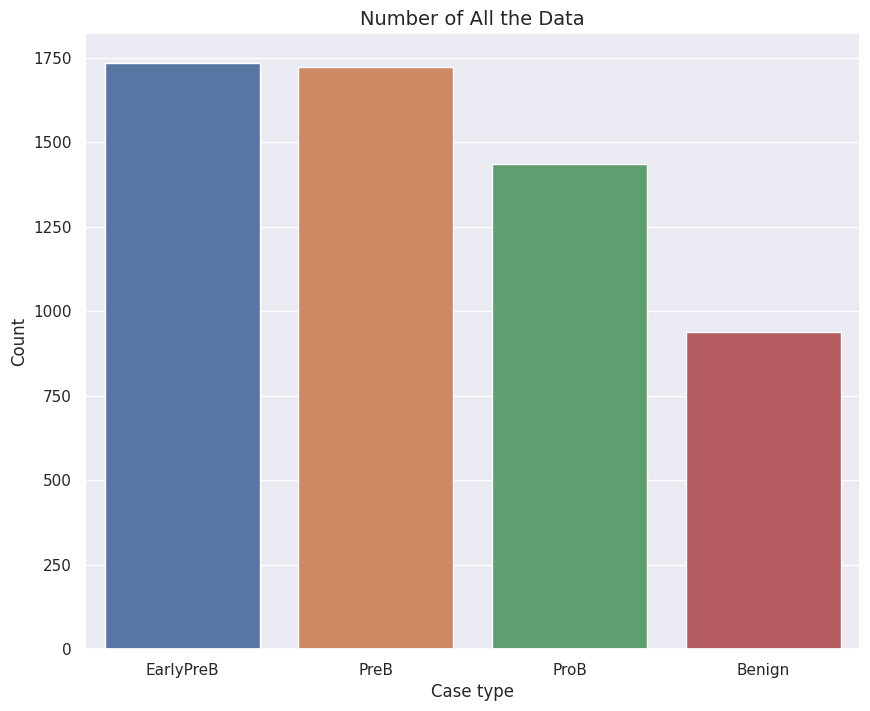

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="darkgrid")
plt.figure(figsize=(10,8))
sns.barplot(x= ['EarlyPreB','PreB','ProB','Benign'], y= [a[0],a[1],a[2],a[3]])
plt.title('Number of All the Data', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
#plt.xticks(range(len(df.index)), ['a', 'b'])
plt.show()

2-2: Split the data frame for training and validation sets



In [13]:
SPLIT= 0.90

TRAIN_DF, VALID_DF = train_test_split(df, train_size=SPLIT, shuffle=True, random_state=88)

print('Train samples: ', len(TRAIN_DF))
print('Valid samples: ', len(VALID_DF))
print('Test samples : ', len(test_df))

Train samples:  5250
Valid samples:  584
Test samples :  325


In [14]:
test_df['labels'].value_counts()

labels
EarlyPreB    111
PreB          93
ProB          78
benign        43
Name: count, dtype: int64

In [15]:
BATCH_SIZE= 32
IMG_SHAPE= (224, 224, 3)
IMG_SIZE= (224, 224)

gen = ImageDataGenerator(rescale=1./255, 
                         vertical_flip=True,
                         horizontal_flip=True)
                         #rotation_range=10)

gen2 = ImageDataGenerator(rescale=1./255)

train_gen = gen.flow_from_dataframe(TRAIN_DF,
                                    x_col= 'filenames',
                                    y_col= 'labels',
                                    target_size= IMG_SIZE,
                                    class_mode= 'categorical',
                                    color_mode= 'rgb',
                                    shuffle= True,
                                    batch_size= BATCH_SIZE,
                                    seed=88
)

valid_gen= gen2.flow_from_dataframe(VALID_DF,
                                    x_col= 'filenames',
                                    y_col= 'labels',
                                    target_size= IMG_SIZE,
                                    class_mode= 'categorical',
                                    color_mode= 'rgb',
                                    shuffle= True,
                                    batch_size= BATCH_SIZE,
                                    seed=88
)
test_gen= gen2.flow_from_dataframe(test_df,
                                   x_col= 'filenames',
                                   y_col= 'labels',
                                   target_size= IMG_SIZE,
                                   class_mode= 'categorical',
                                   color_mode= 'rgb',
                                   shuffle= True,
                                   batch_size= 325,
                                   seed=88
)


STEPS= int( len(train_gen.labels)/BATCH_SIZE)
print(STEPS)


Found 5250 validated image filenames belonging to 4 classes.
Found 584 validated image filenames belonging to 4 classes.
Found 325 validated image filenames belonging to 4 classes.
164


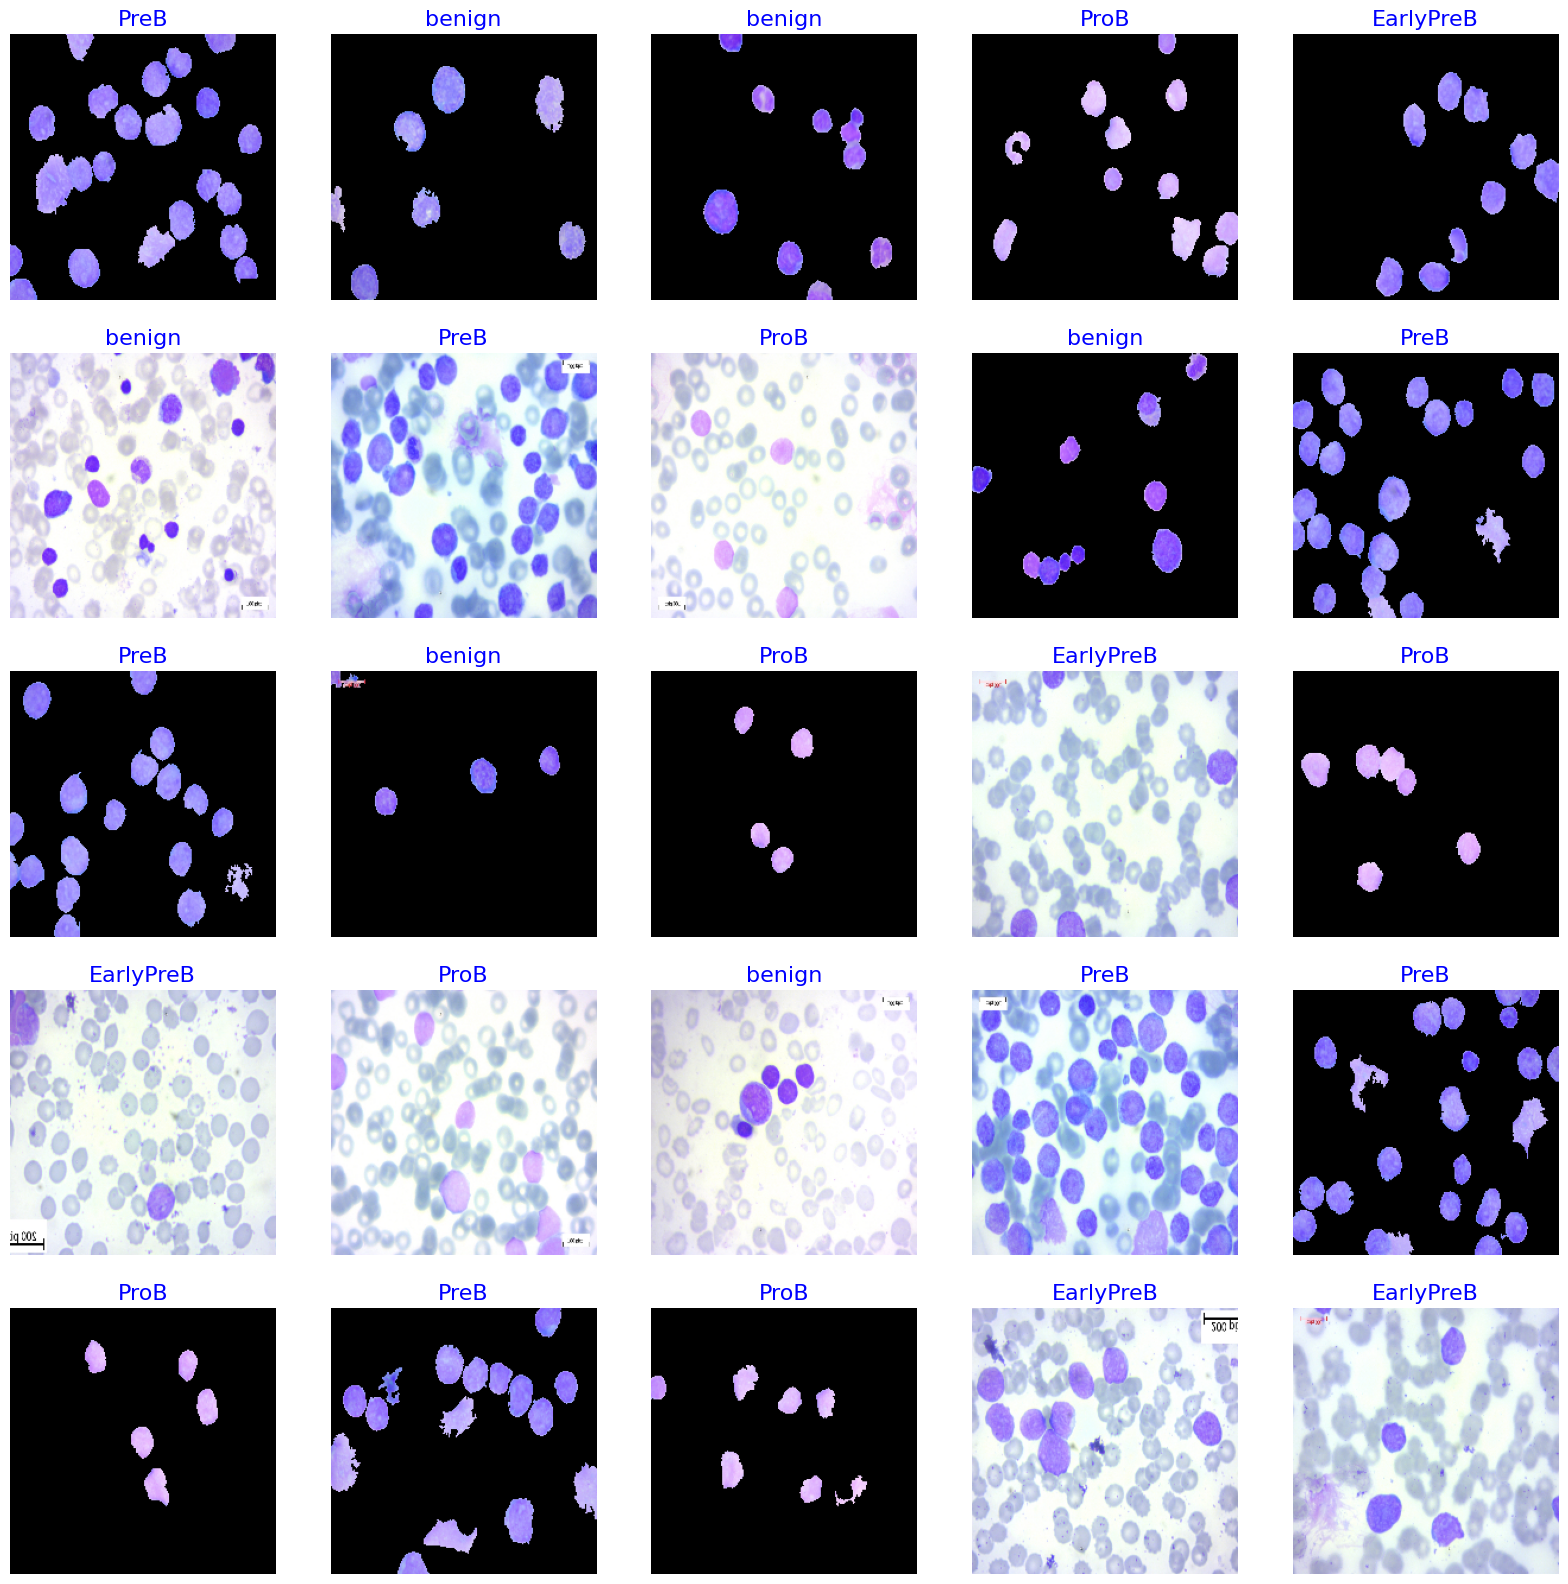

In [16]:
genn=train_gen
class_dictionary= genn.class_indices
class_names = list(class_dictionary.keys())
images, labels = next(genn) #get sample batch from the generator
plt.figure(figsize=(20,20))
length = len(labels)

if length<25:
    r=length
else:
    r=25

for i in range(r):
    plt.subplot(5, 5, i+1)
    image= (images[i])
    #image= cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    index=np.argmax(labels[i])
    class_name= class_names[index]
    plt.title(class_name, color='blue', fontsize=16)
    plt.axis('off')
plt.show()

In [ ]:
#base_model = InceptionV3(include_top= False, weights="imagenet", input_shape=(224,224,3))
#base_model= tf.keras.applications.efficientnet.EfficientNetB0(include_top=False,weights='imagenet',input_shape=(224,224,3))
#tf.keras.applications.nasnet.NASNetLarge
#base_model= tf.keras.applications.nasnet.NASNetMobile(include_top=False,weights='imagenet',input_shape=(224,224,3))
base_model= tf.keras.applications.mobilenet_v2.MobileNetV2(include_top=False,weights='imagenet',input_shape=(224,224,3))
#tf.keras.applications.MobileNetV3Small

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x) 
#x = Dense(128, activation= 'relu',kernel_initializer='he_uniform')(x)
#x = BatchNormalization()(x)
#x = Dropout(0.3)(x)
predictions = Dense(4, activation= "softmax")(x) 
model = Model(inputs=base_model.input, outputs=predictions) 

I0000 00:00:1748184099.949801      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1748184099.950551      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [18]:
print(base_model.input)
model.summary()

<KerasTensor shape=(None, 224, 224, 3), dtype=float32, sparse=False, name=keras_tensor>


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,268,228 (8.65 MB)

 Trainable params: 2,231,556 (8.51 MB)

 Non-trainable params: 36,672 (143.25 KB)

3-2: Model parameters



In [22]:
initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=40,
    decay_rate=0.96,
    staircase=False)


model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.999, epsilon=1e-08), #optimizer=Adam(learning_rate=0.00001,decay = 10e-5),
              metrics=['accuracy'])
             # option = run_opts)

3-2: Model training



In [23]:
history =         model.fit(x=train_gen,
                            epochs=30,
                            validation_data=valid_gen,
                            steps_per_epoch=None,
                            
                   )

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1748184207.179911   58524 service.cc:148] XLA service 0x7bffd4002230 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748184207.180805   58524 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1748184207.180826   58524 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1748184210.314224   58524 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1748184227.806294   58524 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of th

165/165 ━━━━━━━━━━━━━━━━━━━━ 96s 238ms/step - accuracy: 0.8171 - loss: 0.4805 - val_accuracy: 0.3390 - val_loss: 3.0337
Epoch 2/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 17s 105ms/step - accuracy: 0.9609 - loss: 0.1063 - val_accuracy: 0.4144 - val_loss: 3.1637
Epoch 3/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 18s 106ms/step - accuracy: 0.9687 - loss: 0.0870 - val_accuracy: 0.3955 - val_loss: 4.0333
Epoch 4/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 18s 108ms/step - accuracy: 0.9796 - loss: 0.0547 - val_accuracy: 0.4521 - val_loss: 3.0443
Epoch 5/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 19s 112ms/step - accuracy: 0.9848 - loss: 0.0527 - val_accuracy: 0.5976 - val_loss: 2.2220
Epoch 6/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 18s 111ms/step - accuracy: 0.9854 - loss: 0.0413 - val_accuracy: 0.6079 - val_loss: 1.6290
Epoch 7/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 18s 108ms/step - accuracy: 0.9854 - loss: 0.0419 - val_accuracy: 0.6507 - val_loss: 1.2165
Epoch 8/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 18s 108ms/step - accuracy: 0.9889 - loss: 0.0343 - val

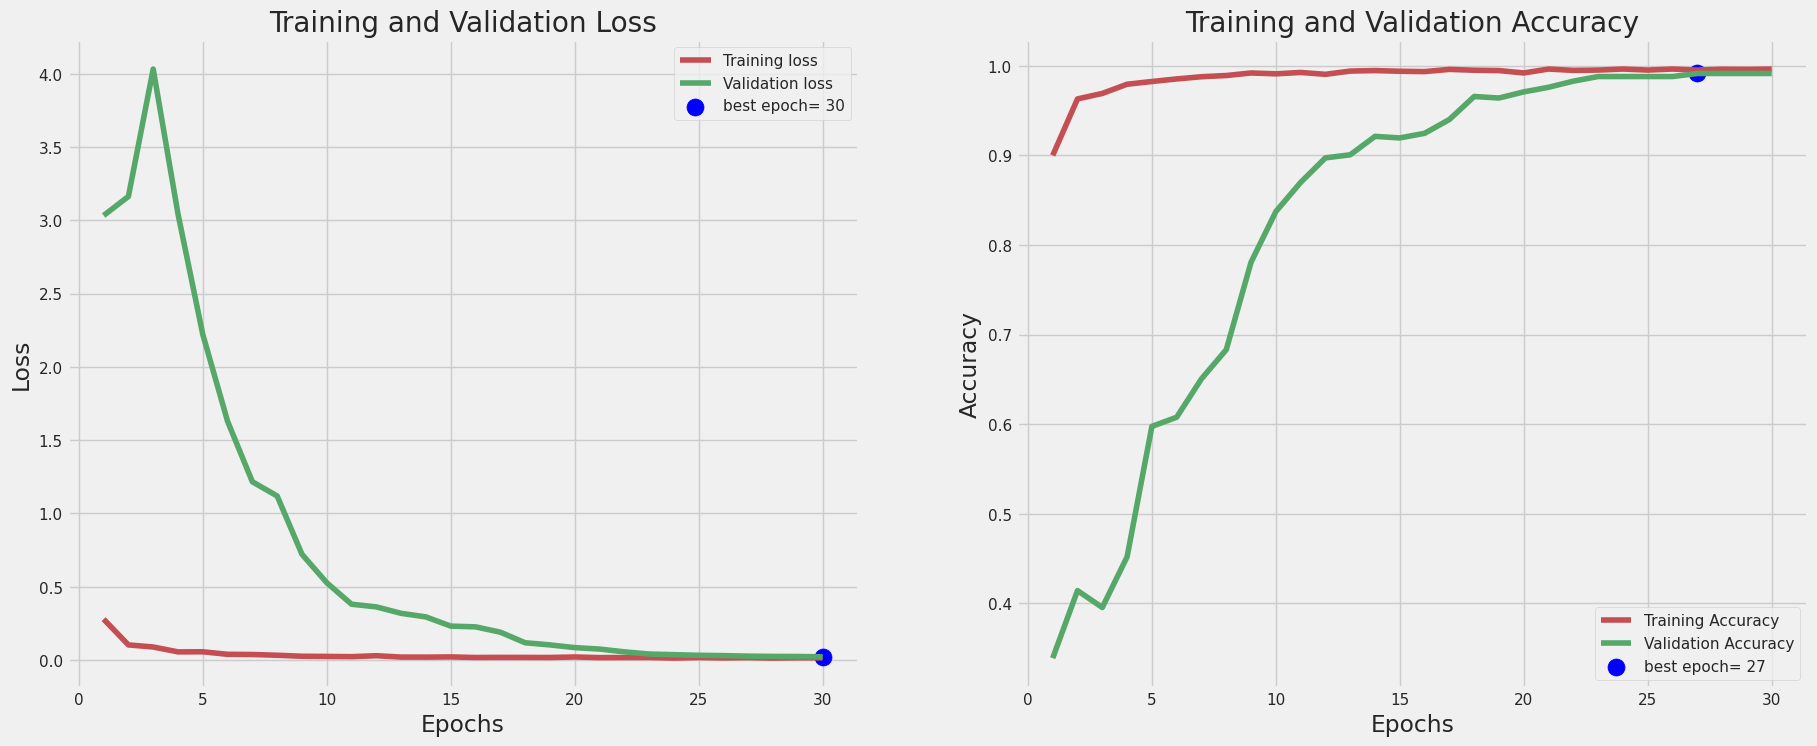

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2025-05-25 14:53:23.783726: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng42{k2=2,k4=1,k5=0,k6=0,k7=0} for conv (f32[325,32,112,112]{3,2,1,0}, u8[0]{0}) custom-call(f32[325,32,112,112]{3,2,1,0}, f32[32,1,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=32, custom_call_target="__cudnn$convForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025

1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step - accuracy: 1.0000 - loss: 0.0040
Model accuracy on test set: 100.0 (0, 255, 0) (55, 65, 80)


In [24]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()
    
    
tr_plot(history, 0)
acc=model.evaluate(test_gen,batch_size=32, steps=None, verbose=1)[1]*100
msg='Model accuracy on test set: ' + str(acc)
print(msg, (0,255,0), (55,65,80))

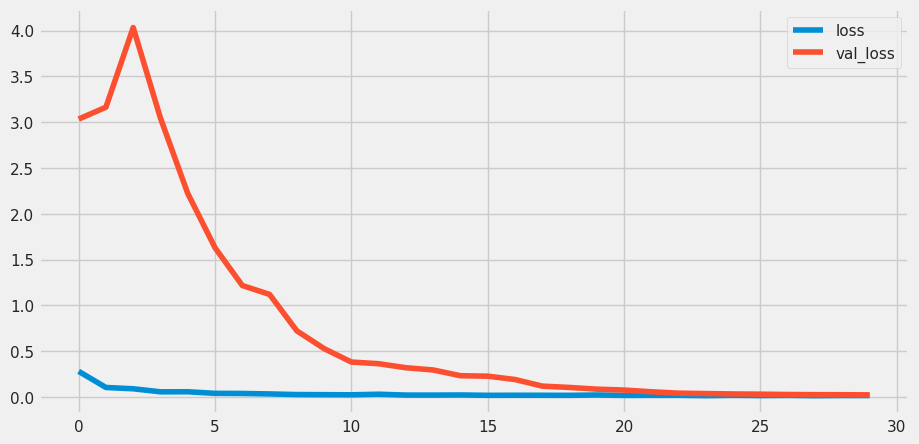

In [25]:
# Plotting train_loss vs val_loss
plt.figure(figsize=(10,5))
plt.plot(history.history["loss"],label="loss")
plt.plot(history.history["val_loss"],label="val_loss")
plt.legend()

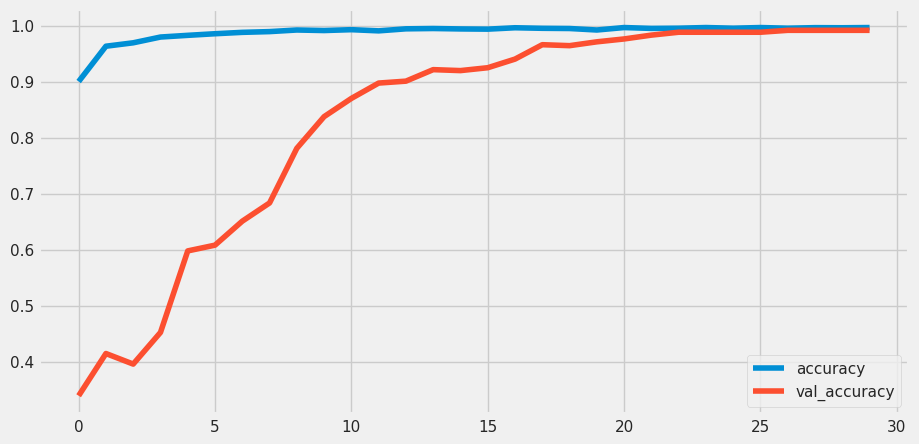

In [26]:
# Plotting train_accuracy vs Val_accuracy
plt.figure(figsize=(10,5))
plt.plot(history.history["accuracy"],label="accuracy")
plt.plot(history.history["val_accuracy"],label="val_accuracy")
plt.legend(loc='lower right')

In [27]:
from sklearn.metrics import confusion_matrix


for X_batch, y_batch in test_gen:
    y_test = y_batch
    X_test = X_batch
    break
    
print('test label shape',y_test.shape)
print('test image shape',X_test.shape)
print('Evaluate on test-data:')
model.evaluate(X_test,y_test)

pred = model.predict(X_test)

bin_predict = np.argmax(pred,axis=1)
y_test = np.argmax(y_test,axis=1)


#Confusion matrix:
matrix = confusion_matrix(y_test, bin_predict)
print('Confusion Matrix:\n',matrix)

test label shape (325, 4)
test image shape (325, 224, 224, 3)
Evaluate on test-data:
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 276ms/step - accuracy: 1.0000 - loss: 0.0050
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 350ms/step
Confusion Matrix:
 [[111   0   0   0]
 [  0  93   0   0]
 [  0   0  78   0]
 [  0   0   0  43]]


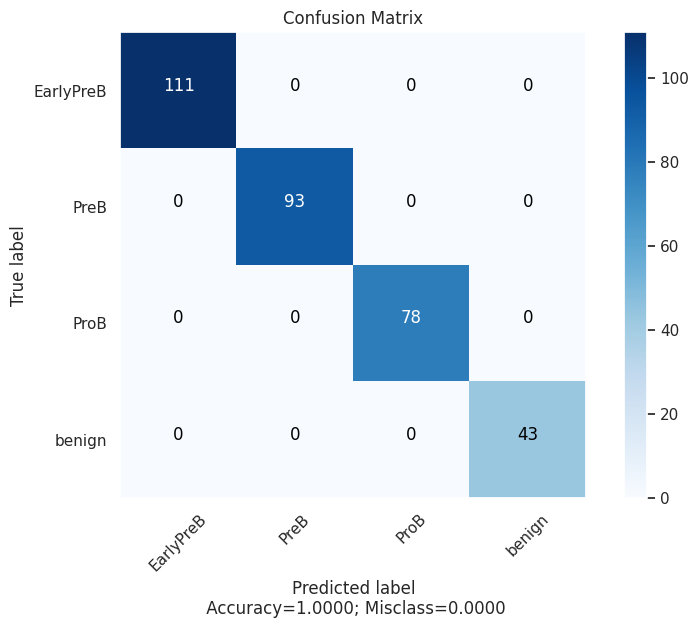

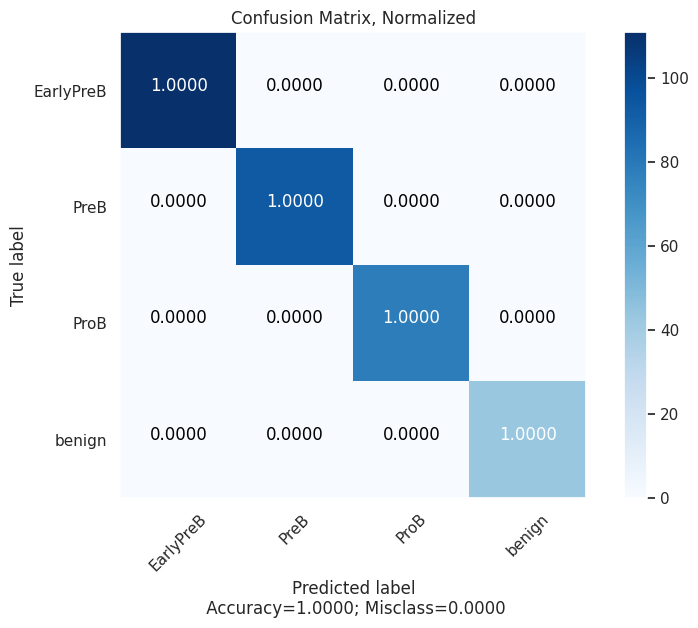

In [28]:
import itertools

#Plot the Confusion matrix:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    sns.set(style="dark")
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\n Accuracy={:0.4f}; Misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

    
plot_confusion_matrix(cm           = np.array(matrix), 
                      normalize    = False,
                      target_names = ['EarlyPreB','PreB','ProB','benign'],
                      title        = "Confusion Matrix")

plot_confusion_matrix(cm           = np.array(matrix), 
                      normalize    = True,
                      target_names = ['EarlyPreB','PreB','ProB','benign'],
                      title        = "Confusion Matrix, Normalized")

In [29]:
class_metrics = metrics.classification_report(y_test,bin_predict,labels=[0, 1])
print(class_metrics)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       111
           1       1.00      1.00      1.00        93

   micro avg       1.00      1.00      1.00       204
   macro avg       1.00      1.00      1.00       204
weighted avg       1.00      1.00      1.00       204



In [30]:
FP = matrix.sum(axis=0) - np.diag(matrix)
FN = matrix.sum(axis=1) - np.diag(matrix)
TP = np.diag(matrix)
TN = matrix[:].sum() - (FP + FN + TP)

TPR = TP/(TP+FN)
TNR = TN/(TN+FP) 
PPV = TP/(TP+FP)
NPV = TN/(TN+FN)
FPR = FP/(FP+TN)
FNR = FN/(TP+FN)
FDR = FP/(TP+FP)

ACC = (TP+TN)/(TP+FP+FN+TN)

print('Other Metrics:')
MAE = mean_absolute_error(y_test, bin_predict)

print('MAE ----------------------------------------------:', MAE)
print('Accuracy -----------------------------------------:', ACC)
print('Precision (positive predictive value)-------------:', PPV)
print('Recall (Sensitivity, hit rate, true positive rate):', TPR)
print('Specificity (true negative rate)------------------:', TNR)
print('Negative Predictive Value-------------------------:', NPV)
print('Fall out (false positive rate)--------------------:', FPR)
print('False Negative Rate-------------------------------:', FNR)
print('False discovery rate------------------------------:', FDR)

Other Metrics:
MAE ----------------------------------------------: 0.0
Accuracy -----------------------------------------: [1. 1. 1. 1.]
Precision (positive predictive value)-------------: [1. 1. 1. 1.]
Recall (Sensitivity, hit rate, true positive rate): [1. 1. 1. 1.]
Specificity (true negative rate)------------------: [1. 1. 1. 1.]
Negative Predictive Value-------------------------: [1. 1. 1. 1.]
Fall out (false positive rate)--------------------: [0. 0. 0. 0.]
False Negative Rate-------------------------------: [0. 0. 0. 0.]
False discovery rate------------------------------: [0. 0. 0. 0.]


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Shape of preds:  (325, 4)


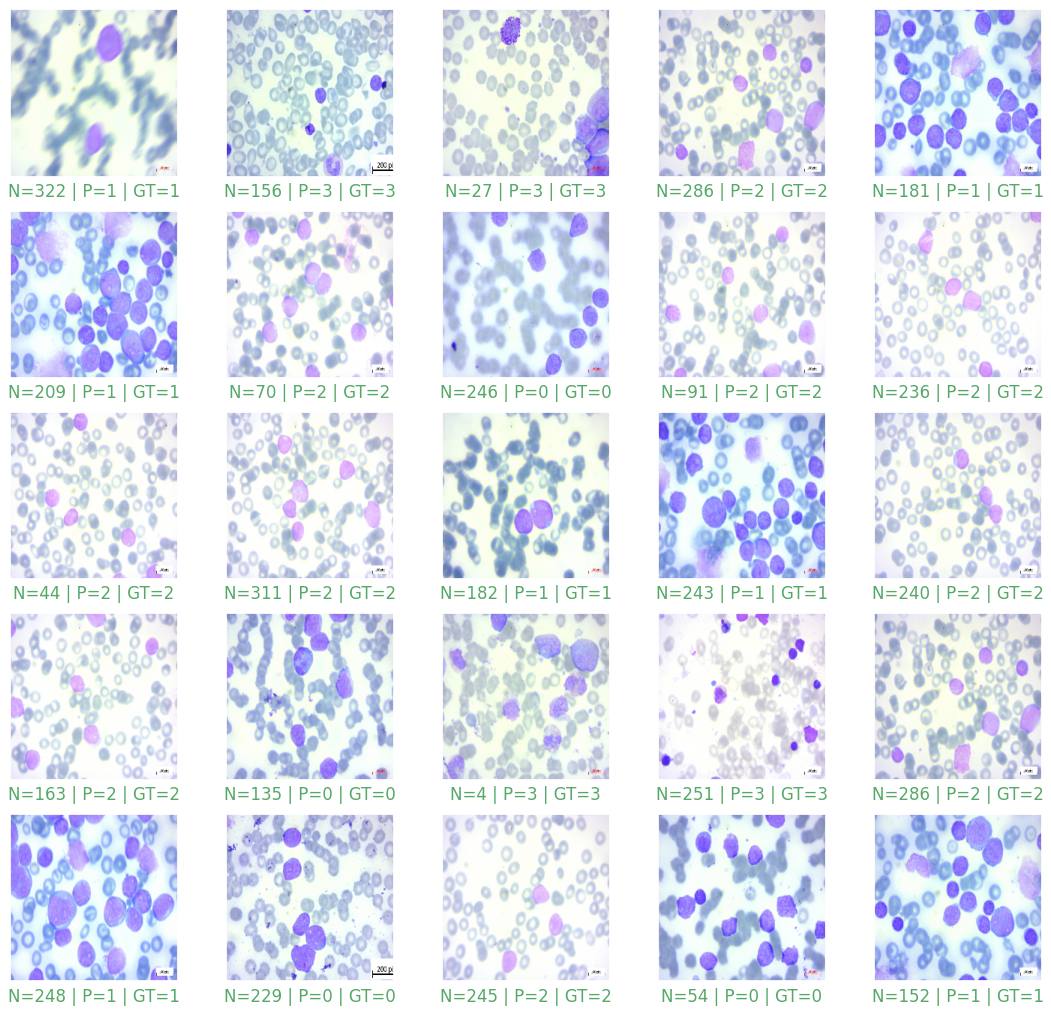

In [31]:
preds = model.predict(X_test)
#print(preds)
print('Shape of preds: ', preds.shape)
plt.figure(figsize = (12, 12))

number = np.random.choice(preds.shape[0])

for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    number = np.random.choice(preds.shape[0])
    pred = np.argmax(preds[number])
    actual = (y_test[number])
    col = 'g'
    if pred != actual:
        col = 'r'
    plt.xlabel('N={} | P={} | GT={}'.format(number, pred, actual), color = col) #N= number P= prediction GT= actual (ground truth)
    image= X_test[number]#cv2.cvtColor(X_test[number], cv2.COLOR_BGR2RGB)
    plt.imshow(((image* 255).astype(np.uint8)), cmap='binary')
plt.show()

Step 5: Save the model


In [36]:
import tensorflow as tf  # Needed for tf.lite

# Check working directory
!ls /kaggle/working

# Create directory to save the model if not already exists
!mkdir -p /kaggle/working/model4

# Convert Keras model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tfmodel = converter.convert()

# Save the .tflite model
with open('/kaggle/working/model4/model4.tflite', 'wb') as f:
    f.write(tfmodel)

# Optionally save the full Keras model (commented)
# model.save("/kaggle/working/Model1/model1")


model4
Saved artifact at '/tmp/tmp6yi804wk'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  136342871040528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136342871041104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136342871034960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136342871034768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136342871041488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136342871034384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136342871035536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136342871033808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136342871034192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136342871041296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1363428

W0000 00:00:1748185320.028046      35 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1748185320.028088      35 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.


In [37]:
import os
os.chdir(r'./')
from IPython.display import FileLink
FileLink(r'./model4/model4.tflite')

/kaggle/working/model4/model4.tflite

In [ ]:
import shutil
import os
from IPython.display import FileLink

# Create a ZIP file from the 'model3' directory
shutil.make_archive('model4', 'zip', './model4')

# Change directory to current working path (optional, usually already there)
os.chdir('./')

# Create a download link for the ZIP file
FileLink('model4.zip')


/kaggle/working/model4.zip

In [13]:
! pip install gradio


Defaulting to user installation because normal site-packages is not writeable


In [15]:
import gradio as gr
import tensorflow as tf
import numpy as np
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt

# Load TFLite model and allocate tensors
interpreter = tf.lite.Interpreter(model_path="model4.tflite")
interpreter.allocate_tensors()

# Get input and output tensor info
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Correct class labels order
class_names = ['EarlyPreB', 'PreB', 'ProB', 'Benign']

# Prediction + visualization function
def predict(image):
    # Preprocess the image
    image = image.resize((224, 224))
    img = np.array(image).astype(np.float32) / 255.0
    img = np.expand_dims(img, axis=0)

    # Run inference
    interpreter.set_tensor(input_details[0]['index'], img)
    interpreter.invoke()
    preds = interpreter.get_tensor(output_details[0]['index'])[0]

    # Plot probabilities using seaborn barplot
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.barplot(x=class_names, y=preds, palette="viridis", ax=ax)
    ax.set_ylim(0, 1)
    ax.set_ylabel("Probability")
    ax.set_title("Prediction Confidence")

    return fig

# Gradio Interface
interface = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil"),
    outputs=gr.Plot(),
    title="Blood Cancer Cell Classifier",
    description="Upload a blood slide image. The model returns prediction probabilities for: EarlyPreB, PreB, ProB, and Benign."
)

interface.launch()


C:\Users\jayta\AppData\Roaming\Python\Python312\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


* Running on local URL:  http://127.0.0.1:7869
* To create a public link, set `share=True` in `launch()`.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 930ms/step


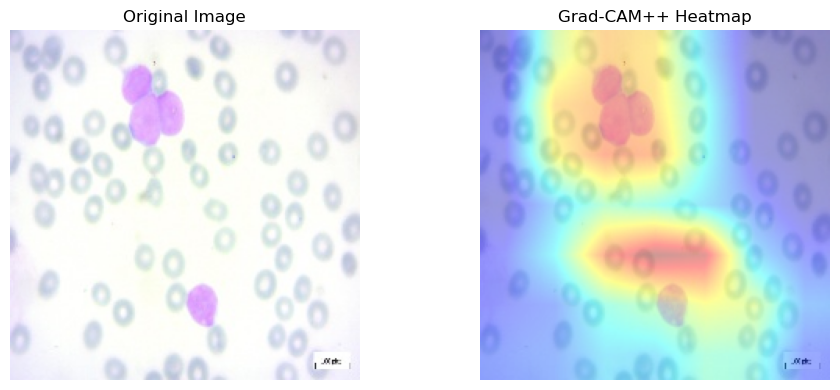

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from PIL import Image

# Load trained model (.h5)
model = tf.keras.models.load_model("model4.h5")

# Preprocess the image for input
def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB").resize((224, 224))
    image = np.array(image).astype(np.float32) / 255.0
    image = np.expand_dims(image, axis=0)
    return image

# Grad-CAM++ calculation
def grad_cam_plus_plus(model, image_array, class_index, layer_name="out_relu"):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape(persistent=True) as tape:
        conv_output, predictions = grad_model(image_array)
        loss = predictions[:, class_index]

        grads = tape.gradient(loss, conv_output)
        grads2 = tape.gradient(tf.reduce_sum(grads), conv_output)
        grads3 = tape.gradient(tf.reduce_sum(grads2), conv_output)

    conv_output = conv_output[0]
    grads = grads[0]
    grads2 = grads2[0]
    grads3 = grads3[0]

    alpha_num = grads2
    alpha_denom = 2.0 * grads2 + grads3 * conv_output
    alpha_denom = tf.where(alpha_denom != 0.0, alpha_denom, tf.ones_like(alpha_denom))
    alphas = alpha_num / alpha_denom

    weights = tf.reduce_sum(alphas * tf.maximum(grads, 0.0), axis=(0, 1))
    cam = tf.reduce_sum(weights * conv_output, axis=-1)

    cam = tf.maximum(cam, 0)
    cam = cam / (tf.reduce_max(cam) + 1e-8)
    return cam.numpy()

# Display Grad-CAM++ overlay
def display_gradcam(image_path, heatmap, alpha=0.4, save_path=None):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224))
    heatmap = cv2.resize(heatmap, (224, 224))

    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(image, 1 - alpha, heatmap_color, alpha, 0)

    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Grad-CAM++ Heatmap")
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    if save_path:
        cv2.imwrite(save_path, overlay)

    plt.tight_layout()
    plt.show()

# Run Grad-CAM++ visualization only
def visualize_gradcam(image_path):
    img_array = preprocess_image(image_path)
    predictions = model.predict(img_array)[0]
    predicted_class = np.argmax(predictions)
    heatmap = grad_cam_plus_plus(model, img_array, predicted_class)
    display_gradcam(image_path, heatmap)

# 🔍 Test on one image (No prediction output)
visualize_gradcam("WBC-Malignant-Pro-027.jpg")  # Replace with your image path
